# Sentiment Analysis from Tweets (Optimised)

This coursework involves further developing and optmising the techniques we previously used to enhance the model's performance further, focusing on balancing the prediction of positive and negative sentiments.

In [1]:
import csv
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from nltk.classify import SklearnClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report # to report on precision and recall
from sklearn.feature_extraction.text import CountVectorizer
#from nltk.stem import PorterStemmer
# nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...


In [2]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process_optimised(text)),label)) #optimised pre-processing
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process_optimised(text)),label)) #optimised pre-processing

## Input and Optimised preprocessing 

In [3]:
def parse_data_line(data_line):
    """Given a tab separated line, returns a tuple containing label and statement."""
    label = data_line[1]
    statement = data_line[2]
    return (label, statement)

In [4]:
#Pre-processing
def pre_process(text):
    """Separates punctuation from the text and splits the text into words."""
    
    #separating punctuation at the end 
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    
    #separating punctuation at the begining
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    
    #tokenisation 
    tokens = re.split(r"\s+",text)
    
    return tokens

In [5]:
#Question 5 - optimisation of pre-processing
def pre_process_optimised(text):
    """Separates punctuation from the text, removes usernames, converts text to lowercase,
    splits the text into words, performs lemmatisation and returns as list of words."""
    
    # Remove URLs
#     text = re.sub(r'http\S+', '', text)
    
    # Remove hashtags
#     text = re.sub(r'\B#\w+\b\s*', '', text)

    # Remove usernames
    text = re.sub(r'\B@\w+\b\s*', '', text)

    #removes punctuation
#     text = re.sub(r'[^\w\s\d]', '', text)
    
    #separating punctuation at the end 
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    
    #separating punctuation at the begining
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    
    #tokenisation 
    tokens = re.split(r"\s+", text)
    
    
    #normalisation
    tokens = [t.lower() for t in tokens]

    #lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    #stemming
#     stemmer = PorterStemmer()
#     tokens = [stemmer.stem(t) for t in tokens]

    # Remove stop words
#     stop_words = set(stopwords.words('english'))
#     tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

Reducing noise and ambiguity in the data is beneficial so that the model could focus on the sentiment alone. Various pre-processing techniques were experimented with to refine the data and isolate sentiment effectively. Removal of URLs & hashtags increased accuracy but removal of stopwords did not improve classifier performance given that the tweets are often made up of short sentences and removing stop words lead to lesser vocabulary. However, the most significant enhancement was observed with the removal of usernames, lemmatization, and normalisation of the text by transforming it into lowercase characters for uniformity, achieving an accuracy of 85.1%

## Optimised Feature Extraction

In [6]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    """Returns a dictionary containing list of word indices (keys) and it's weight (values) 
    corresponding to the frequency of its occurence in the document"""
    
    feature_vector = {}
    for word in tokens:
        #checks if word is present in global dictionary, if it is present the index of the word is retrieved
        if word in global_feature_dict:
            i = global_feature_dict[word]
        else:
            #else the word is added to the global dictionary with an index
            i = len(global_feature_dict)+1
            global_feature_dict[word]=i
            #checks if the index is present in local dictionary, if it is present, more weight is added to the word(repeated word)
        if i in feature_vector:
            feature_vector[i] +=1
        else:
            #else the word is assigned weight 1 (bag of words)
            feature_vector[i]=1
    return feature_vector

In [7]:
#Question 5 - optimisation of feature vector
def to_feature_vector_bigram(text):
    """Utilises sklearn's CountVectorizer to extract features from a string as bigrams."""
    count_vect = CountVectorizer(analyzer='word', ngram_range=(2,2), min_df=1)
    X_train_counts = count_vect.fit_transform([text])
    return count_vect.vocabulary_

def to_feature_vector_ngram(text):
    """Utilises sklearn's CountVectorizer to extract features from a string as n-grams upto 7."""
    count_vect = CountVectorizer(analyzer='word', ngram_range=(1,7))
    X_train_counts = count_vect.fit_transform([text])
    return count_vect.vocabulary_

To improve the model’s performance, Various methods were experimented with to enhance the model's performance by selecting different features through feature engineering techniques. The bag of words method proved to be the best option delivering an accuracy of 85.1%. The use of bigrams yielded the lowest accuracy of 74.6%, while the use of n-grams slightly improved accuracy to 78.6% compared to bigrams. When combined with the pre-processing techniques, the bag of words model with a feature weighting scheme that increments by 1 for each word appearance in the document, remains the most effective.

In [8]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(dual=True))])
    return SklearnClassifier(pipeline).train(data)

In [9]:
#Question 5 - tuning the hyperparameter C of the SVM classifier
def train_classifier_tuned(data, C):
    """Trains the classifier on data based on the given value of regularisation paramater."""
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(C=C, dual=False))])
    return SklearnClassifier(pipeline).train(data)

## Cross-validation

In [10]:
results = []
global best_fold_data #dictionary to save best fold data for error analysis

best_fold_data = { 'max_accuracy': float('-inf') }

def cross_validate(dataset, folds):
    """Performs k-fold cross validation on dataset and returns the average scores of all folds"""

    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Folds start on items %d - %d" % (i, i+fold_size))
        
        # Splitting data into train and test for this fold
        test_data = dataset[i:i + fold_size]
        train_data = dataset[:i] + dataset[i + fold_size: len(dataset)]
        
        # Training the classifier with C=0.1
        classifier = train_classifier_tuned(train_data, 0.1)
        
        # Predicting labels on test set
        test_text = [data[0] for data in test_data]
        test_labels = [data[1] for data in test_data]
        predicted_labels = predict_labels(test_text, classifier)
        
        #calculating metrics for the fold
        fold_classification_report = classification_report(test_labels, predicted_labels, output_dict=True)
        
        #save data of the best fold for error analysis
        if(fold_classification_report['accuracy'] > best_fold_data['max_accuracy']):
            best_fold_data['cv_test_text'] = test_text
            best_fold_data['test_start_index']=i
            best_fold_data['fold_size']=fold_size
            best_fold_data['cv_test_labels'] = test_labels
            best_fold_data['cv_predicted_labels'] = predicted_labels
            best_fold_data['max_accuracy'] = fold_classification_report['accuracy']

        #appending metrics to result variable
        results.append({
        'Accuracy': fold_classification_report['accuracy'],
        'Precision': fold_classification_report['weighted avg']['precision'],
        'Recall': fold_classification_report['weighted avg']['recall'],
        'F1 Score': fold_classification_report['weighted avg']['f1-score']
        })
        
        #print accuracy of each fold
        print("Accuracy: " ,fold_classification_report['accuracy'])
        
    metrics = pd.DataFrame(results)
    
    return metrics.mean()

This approach involves fine-tuning the hyperparameters of the LinearSVC model, such as the choice of kernel, and regularisation parameter etc. The accuracy of the model's prediction for negative sentiments was greatly improved by fine-tuning its parameters, especially adjusting C values revealed that lower C values corresponded to higher accuracy. The accuracy of the model improved to 86.6% at C=0.05, but the precision of classifying negative sentiment decreased. Therefore, the optimal parameter for this dataset was C=0.1

In [11]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [12]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 
print(raw_data[24])
# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)
print(train_data[24])
# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
('waww,, I wanna have it RT @ElmiraGriswold3 @Vah_Raflatahugs wow,ipad got just today free lol www.burna.in/fgye', 'positive')
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
({318: 1, 319: 1, 4: 1, 320: 1, 29: 1, 40: 1, 321: 1, 141: 1, 18: 1, 322: 1, 121: 1, 51: 1, 323: 1, 324: 1, 325: 1, 326: 1, 16: 2, 327: 1, 328: 1}, 'positive')
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
50062


In [13]:
#check pre processed data
print("Data after optimisation of pre-processing techniques")
print(pre_process_optimised(raw_data[24][0]))

Data after optimisation of pre-processing techniques
['waww', ',,', 'i', 'wanna', 'have', 'it', 'rt', 'wow', ',', 'ipad', 'got', 'just', 'today', 'free', 'lol', 'www', '.', 'burna', '.', 'in/fgye']


In [14]:
#Cross validation
print("10 fold Cross Validation on training data after tuning SVM parameters")
cv_results = cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

10 fold Cross Validation on training data after tuning SVM parameters
Folds start on items 0 - 2684
Training Classifier...
Accuracy:  0.8677347242921013
Folds start on items 2684 - 5368
Training Classifier...
Accuracy:  0.8740685543964233
Folds start on items 5368 - 8052
Training Classifier...
Accuracy:  0.8319672131147541
Folds start on items 8052 - 10736
Training Classifier...
Accuracy:  0.8666169895678092
Folds start on items 10736 - 13420
Training Classifier...
Accuracy:  0.8614008941877794
Folds start on items 13420 - 16104
Training Classifier...
Accuracy:  0.8766766020864382
Folds start on items 16104 - 18788
Training Classifier...
Accuracy:  0.8748137108792846
Folds start on items 18788 - 21472
Training Classifier...
Accuracy:  0.8614008941877794
Folds start on items 21472 - 24156
Training Classifier...
Accuracy:  0.8699701937406855
Folds start on items 24156 - 26840
Training Classifier...
Accuracy:  0.8692077727952168


Average scores across all folds
Accuracy     0.865386
Precision    0.864068
Recall       0.865386
F1 Score     0.863965
dtype: float64


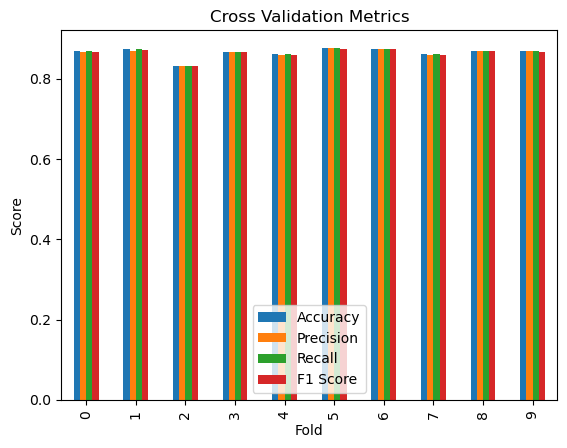

In [15]:
print("Average scores across all folds")
print(cv_results)

# plot the results
fold_metrics = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
fold_metrics.plot(kind='bar', ylabel='Score', xlabel='Fold', title='Cross Validation Metrics')
plt.show()

## Error Analysis 

In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [17]:
def error_analysis():
    """Displays classification report, confusion matrix for the best fold in cross validation step. 
    Prints out the errors to a csv file"""
    
    #fetching the starting index of test data of the best fold
    k = best_fold_data['test_start_index']

    #display the results
    print("Accuracy: ", best_fold_data['max_accuracy'])
    print(classification_report(best_fold_data['cv_test_labels'], best_fold_data['cv_predicted_labels']))
    confusion_matrix_heatmap(best_fold_data['cv_test_labels'], best_fold_data['cv_predicted_labels'], ["negative", "positive"])

    #write errors to csv file
    with open('./error_analysis_tweets_optimised.csv', 'w') as f:
        writer = csv.writer(f)

        #heading
        writer.writerow(['Index', 'Text', 'Label', 'Prediction'])

        #false negatives
        writer.writerow(['False Negatives'])
        index = 1
        for i in range(len(best_fold_data['cv_predicted_labels'])):
            if best_fold_data['cv_predicted_labels'][i] == 'negative' and best_fold_data['cv_test_labels'][i] == 'positive':
                writer.writerow([index,raw_data[k+i][0], best_fold_data['cv_test_labels'][i], best_fold_data['cv_predicted_labels'][i]])
                index += 1

        #false positives
        writer.writerow(['False Positives'])
        index = 1
        for i in range(len(best_fold_data['cv_predicted_labels'])):
            if best_fold_data['cv_predicted_labels'][i] == 'positive' and best_fold_data['cv_test_labels'][i] == 'negative':
                writer.writerow([index,raw_data[k+i][0], best_fold_data['cv_test_labels'][i], best_fold_data['cv_predicted_labels'][i]])
                index += 1

Metrics of the best fold data after optimisation
Accuracy:  0.8766766020864382
              precision    recall  f1-score   support

    negative       0.86      0.77      0.81       931
    positive       0.89      0.93      0.91      1753

    accuracy                           0.88      2684
   macro avg       0.87      0.85      0.86      2684
weighted avg       0.88      0.88      0.88      2684



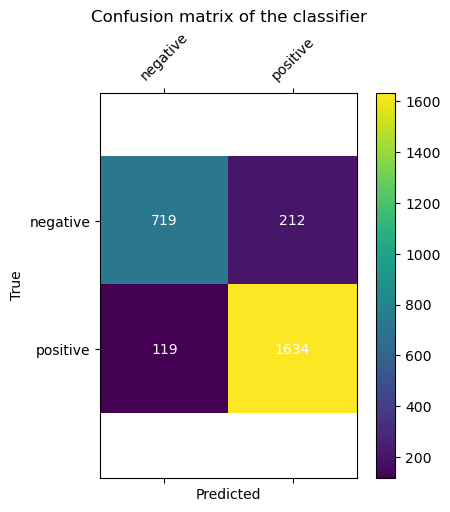

In [18]:
#Perform error analysis
print("Metrics of the best fold data after optimisation")
error_analysis()

In [19]:
#display the error file
csvcheck = pd.read_csv('./error_analysis_tweets_optimised.csv')
csvcheck.head()

,Index,Text,Label,Prediction
0,False Negatives,NaN,NaN,NaN
1,1,Mushu at The Hurricane wearing Tressa's rockst...,positive,negative
2,2,"Hockey home opener. LSI vs. CBA, November 28th...",positive,negative
3,3,@TimWelcomed Since there is a WWE Games group ...,positive,negative
4,4,@OsoFreshFutbol I think the expectations are s...,positive,negative


The combination of preprocessing methods, particularly the removal of usernames, lemmatization, and normalisation, alongside the bag of words feature engineering technique, emerged as the most successful approach. The fine tuning of the SVM's 'C' parameter to 0.1, achieved an overall accuracy of 86.5% and increased recall score from 75% to 77% in analysing the negative sentiment of training data.

## Training and Evaluation

In [20]:
# Finally, check the accuracy of your classifier by training on all the training data
# and testing on the test set
functions_complete = True
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier_tuned(train_data,0.1)  # train the optimised classifier 
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({101: 1, 211: 2, 5: 2, 692: 2, 975: 1, 57: 2, 23994: 1, 92: 1, 56: 1, 43252: 1, 43253: 1, 268: 1, 909: 1, 106: 2, 161: 1, 138: 1, 15595: 1, 22: 1, 2518: 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.866084
Recall: 0.867323
F Score:0.866227


The performance of the classifier was significantly improved by using systematic optimization techniques and was able to achieve an accuracy of 86.7% on test data.